# email

In [15]:
## SETUP UNTUK CLUSTERING EMAIL

import pandas as pd
import numpy as np
import time
from ast import literal_eval # PENTING: Untuk membaca kolom 'tokens' dari CSV

# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

# Import untuk Clustering
from sklearn.cluster import KMeans

# Import untuk Visualisasi
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score # Import Silhouette Score


print("Semua library untuk clustering berhasil diimpor.")

Semua library untuk clustering berhasil diimpor.


In [8]:
# Memuat Dataset 
try:
    df = pd.read_csv('hasil_preprocessing_emailUTS.csv')
    print(f"\nDataset berhasil dimuat. Jumlah data: {len(df)} baris.")
    print("Contoh data awal:")
    print(df.head())
except FileNotFoundError:
    print("\nError: File tidak ditemukan. Pastikan nama file CSV sudah benar.")
    # Jika file tidak ditemukan, hentikan proses.
    # df = pd.DataFrame()


Dataset berhasil dimuat. Jumlah data: 5572 baris.
Contoh data awal:
                                                Text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                 hasil_preprocessing  
0  ['go', 'jurong', 'point', 'crazy', 'available'...  
1         ['ok', 'lar', 'joking', 'wif', 'u', 'oni']  
2  ['free', 'entry', 'wkly', 'comp', 'win', 'fa',...  
3  ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', ...  
4  ['nah', 'dont', 'think', 'goes', 'usf', 'lives...  


In [9]:
df['tokens'] = df['hasil_preprocessing'].apply(literal_eval)
print(f"Data bersih dimuat. Jumlah data: {len(df)} baris.")

Data bersih dimuat. Jumlah data: 5572 baris.



Kamus dibuat dan difilter. Jumlah kata unik: 602

--- Menjalankan HDP untuk estimasi jumlah topik... ---
✅ HDP mengestimasi ada sekitar: 20 topik.

--- Menjalankan pencarian koherensi dari 5 hingga 40 topik... ---
Selesai menghitung untuk 5 topik. Skor Koherensi: 0.3769
Selesai menghitung untuk 10 topik. Skor Koherensi: 0.3775
Selesai menghitung untuk 15 topik. Skor Koherensi: 0.3822
Selesai menghitung untuk 20 topik. Skor Koherensi: 0.3394
Selesai menghitung untuk 25 topik. Skor Koherensi: 0.3750
Selesai menghitung untuk 30 topik. Skor Koherensi: 0.3674
Selesai menghitung untuk 35 topik. Skor Koherensi: 0.3912

Total waktu pencarian koherensi: 2.27 menit


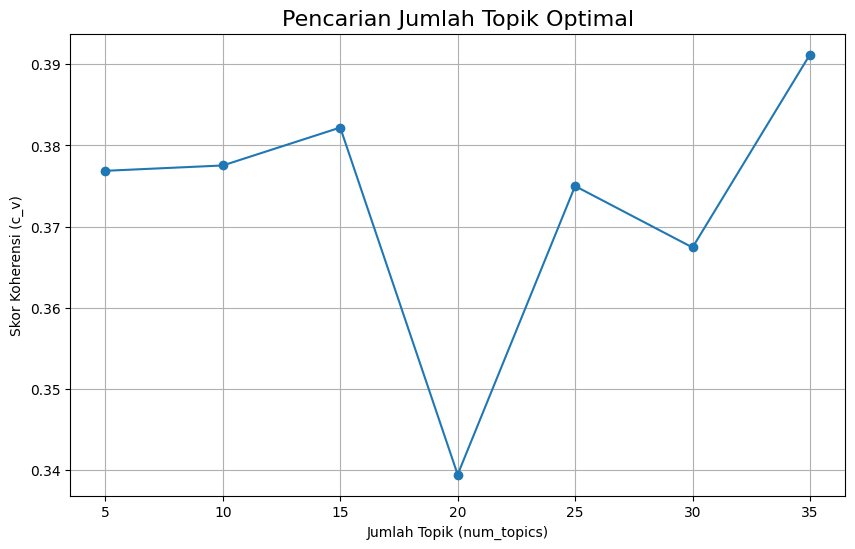


✅ Jumlah topik optimal yang ditemukan: 35

--- Melatih model LDA final dengan topik optimal... ---

--- Topik-topik yang Ditemukan oleh Model LDA ---
Topik: 24
Kata-kata: 0.088*"take" + 0.080*"yes" + 0.067*"way" + 0.065*"ya" + 0.046*"keep" + 0.039*"care" + 0.037*"hello" + 0.027*"name" + 0.022*"make" + 0.021*"u" + 0.021*"nice" + 0.020*"girl" + 0.018*"coz" + 0.018*"book" + 0.017*"must"

Topik: 3
Kata-kata: 0.151*"got" + 0.042*"things" + 0.041*"another" + 0.037*"shes" + 0.029*"bored" + 0.025*"means" + 0.025*"like" + 0.025*"back" + 0.023*"waiting" + 0.022*"online" + 0.020*"chat" + 0.018*"go" + 0.018*"haf" + 0.017*"busy" + 0.016*"congrats"

Topik: 2
Kata-kata: 0.057*"å" + 0.042*"gift" + 0.041*"forgot" + 0.037*"draw" + 0.035*"last" + 0.031*"came" + 0.030*"ur" + 0.029*"wish" + 0.028*"even" + 0.027*"week" + 0.026*"txt" + 0.026*"word" + 0.025*"free" + 0.023*"trip" + 0.023*"ring"

Topik: 6
Kata-kata: 0.137*"call" + 0.065*"prize" + 0.053*"å" + 0.040*"claim" + 0.034*"urgent" + 0.032*"u" + 0.032*"

In [11]:
## EKSTRAKSI FITUR LDA & PENCARIAN TOPIK OPTIMAL

# Siapkan data untuk Gensim
documents = df['tokens'].tolist()
dictionary = Dictionary(documents)
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f"\nKamus dibuat dan difilter. Jumlah kata unik: {len(dictionary)}")


# Estimasi Jumlah Topik dengan HDP 
print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
estimated_num_topics = len(hdp_model.print_topics())
print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")


# Mencari Jumlah Topik Terbaik dengan Plot Koherensi 
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    start_time = time.time()
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=42, passes=10, workers=3)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        current_coherence = coherencemodel.get_coherence()
        coherence_values.append(current_coherence)
        print(f"Selesai menghitung untuk {num_topics} topik. Skor Koherensi: {current_coherence:.4f}")
    total_time = time.time() - start_time
    print(f"\nTotal waktu pencarian koherensi: {total_time/60:.2f} menit")
    return coherence_values

# Atur rentang pencarian di sekitar hasil HDP
search_start = max(2, estimated_num_topics - 15)
search_limit = estimated_num_topics + 20
search_step = 5

print(f"\n--- Menjalankan pencarian koherensi dari {search_start} hingga {search_limit} topik... ---")
coherence_values = compute_coherence_values_multicore(dictionary=dictionary, corpus=corpus, texts=documents,
                                                    start=search_start, limit=search_limit, step=search_step)

# Tampilkan grafik
x = range(search_start, search_limit, search_step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title("Pencarian Jumlah Topik Optimal", fontsize=16)
plt.xlabel("Jumlah Topik (num_topics)")
plt.ylabel("Skor Koherensi (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# Pilih jumlah topik terbaik (yang memiliki skor koherensi tertinggi)
optimal_num_topics = x[np.argmax(coherence_values)]
print(f"\n✅ Jumlah topik optimal yang ditemukan: {optimal_num_topics}")


# Latih Model LDA Final & Ekstrak Fitur ---
print("\n--- Melatih model LDA final dengan topik optimal... ---")
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics,
                         random_state=42, passes=15)

print("\n--- Topik-topik yang Ditemukan oleh Model LDA ---")
    # Tampilkan 15 kata teratas untuk setiap topik
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"Topik: {idx}")
    print(f"Kata-kata: {topic}\n")

# Ekstrak fitur (distribusi topik) untuk setiap dokumen
def get_lda_features(lda_model, bow_corpus):
    features = []
    for doc_bow in bow_corpus:
        topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_features = [0.0] * optimal_num_topics
        for topic_id, prob in topic_distribution:
            doc_features[topic_id] = prob
        features.append(doc_features)
    return np.array(features)

X = get_lda_features(lda_model, corpus)

print("Ekstraksi fitur LDA selesai.")
print(f"Bentuk matriks fitur (X): {X.shape}")


--- Mencari K Optimal dengan Silhouette Score (Metode Kuantitatif) ---
Untuk K = 2, Silhouette Score-nya adalah 0.0065
Untuk K = 3, Silhouette Score-nya adalah 0.0180
Untuk K = 4, Silhouette Score-nya adalah 0.0356
Untuk K = 5, Silhouette Score-nya adalah 0.0380
Untuk K = 6, Silhouette Score-nya adalah 0.0565
Untuk K = 7, Silhouette Score-nya adalah 0.0691
Untuk K = 8, Silhouette Score-nya adalah 0.0964
Untuk K = 9, Silhouette Score-nya adalah 0.1151
Untuk K = 10, Silhouette Score-nya adalah 0.1270
Untuk K = 11, Silhouette Score-nya adalah 0.1418
Untuk K = 12, Silhouette Score-nya adalah 0.1494
Untuk K = 13, Silhouette Score-nya adalah 0.1663
Untuk K = 14, Silhouette Score-nya adalah 0.1824
Untuk K = 15, Silhouette Score-nya adalah 0.1935


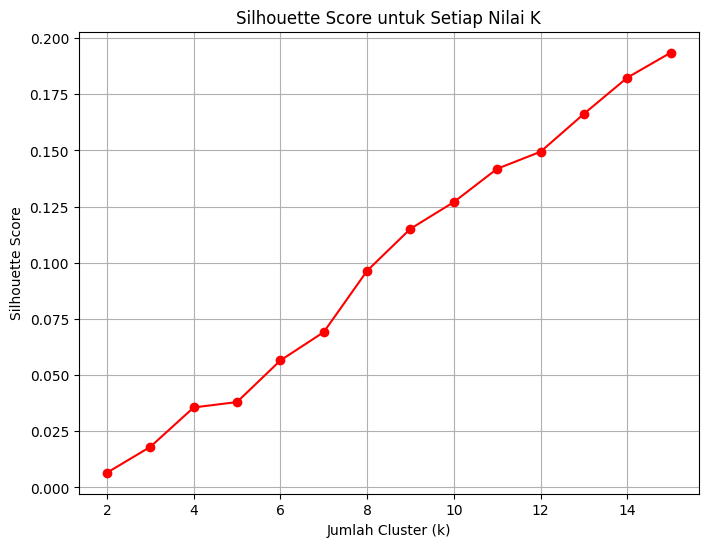


✅ Berdasarkan Silhouette Score, K terbaik adalah: 15

--- Menjalankan K-Means final dengan K=15... ---

Contoh email dari setiap cluster yang ditemukan:

----- CLUSTER 0 -----
- I HAVE A DATE ON SUNDAY WITH WILL!!...
- XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL...

----- CLUSTER 1 -----
- U dun say so early hor... U c already then say......
- Fine if thatåÕs the way u feel. ThatåÕs the way its gota b...

----- CLUSTER 2 -----
- I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today....
- Just forced myself to eat a slice. I'm really not hungry tho. This sucks. Mark is getting worried. He knows I'm sick when I turn down pizza. Lol...

----- CLUSTER 3 -----
- Fair enough, anything going on?...
- Yeah hopefully, if tyler can't do it I could maybe ask around a bit...

----- CLUSTER 4 -----
- Nah I don't think he goes to usf, he li

In [ ]:
# Menemukan K Optimal dengan Silhouette Score 
print("\n--- Mencari K Optimal dengan Silhouette Score (Metode Kuantitatif) ---")
K_range = range(2, 16)
silhouette_scores = []
for k in K_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    score = silhouette_score(X, kmeans_model.labels_)
    silhouette_scores.append(score)
    print(f"Untuk K = {k}, Silhouette Score-nya adalah {score:.4f}")

# Visualisasikan hasilnya
plt.figure(figsize=(8, 6)) # Ukuran plot disesuaikan
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Setiap Nilai K')
plt.grid(True)
plt.show()

# Jalankan K-Means dengan K Terbaik 
# Pilih K yang memberikan Silhouette Score TERTINGGI secara otomatis
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Berdasarkan Silhouette Score, K terbaik adalah: {optimal_k}")

print(f"\n--- Menjalankan K-Means final dengan K={optimal_k}... ---")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
# Ganti 'df' dengan nama DataFrame yang berisi data bersih Anda
df['cluster'] = kmeans.fit_predict(X)

# Analisis Hasil Cluster ---
print("\nContoh email dari setiap cluster yang ditemukan:")
for i in range(optimal_k):
    print(f"\n----- CLUSTER {i} -----")
    sample_emails = df[df['cluster'] == i]['Text'].head(2).tolist()
    for email_text in sample_emails:
        print(f"- {str(email_text)[:250]}...")

print("\n✅ Proses clustering selesai.")

In [22]:
# SIMPAN HASIL AKHIR KE CSV
NAMA_FILE_HASIL = 'hasil_clustering_emailUTS.csv'
df.to_csv(NAMA_FILE_HASIL, index=False)
print(f"\n✅ Hasil clustering lengkap telah disimpan ke file '{NAMA_FILE_HASIL}'")


✅ Hasil clustering lengkap telah disimpan ke file 'hasil_clustering_emailUTS.csv'
